<h3>Linear regression lab 2</h3>


#### Aims 

* Practice general linear regression with polynomial and RBF 
* Choose the order of polynomials with cross validation
* Practice ridge regression


#### Tasks 
* Rescale
* Write functions to construct the design matrix, $X$, with polynomials and RBFs
* Implement cross-validation to choose the right polynoimal order
* Test polynoimal regression and cross-validation on new data where the true order is known
* Test ridge regression
* Test linear regression with the RBF

#### Task 1: Again, we start by loading the Olympic 100m men's data

In [1]:
import numpy as np 
%matplotlib inline
import pylab as plt

data = np.loadtxt('olympic100m.txt', delimiter = ',')
x = data[:, 0][:, None]  # Make x a matrix.
t = data[:, 1][:, None]  # Make t a column vector.

#### Task 2: Perform Polynomial Regression on the Olympic data

#### Task 2.1 Rescale $x$ 
We rescale $x$ to make it small. Doing so will stablise the computatoin, otherwise it quickly becomes unfeasible to fit polynomials over ~$2000$. Let's test the following two options:
- Option 1: `(x-1896)/40`
- Option 2: `(x-np.mean(x))/np.std(x) `

In [2]:
def transform(x):
    '''
    Perform rescaling.

    Parameters
    ----------
    x : data to be rescaled

    Returns
    -------
    data : rescaled data
    '''

    # return (x - 1896) / 40
    return (x - np.mean(x)) / np.std(x)

Test both options.

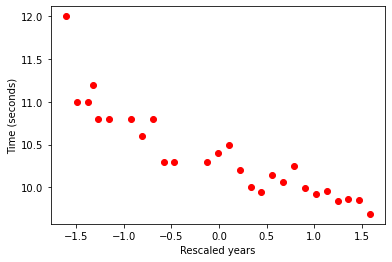

In [3]:
x = transform(x)  # Rescale x.
plt.plot(x, t, 'ro')
plt.xlabel('Rescaled years')
plt.ylabel('Time (seconds)')
plt.show()

#### Task 2.2 Write you own function to construct the design matrix with polynomials

$$
\mathbf{X} = \begin{bmatrix}
    1       & x_{1} & x_{1}^2 & \dots & x_{1}^K \\
    1       & x_{2} & x_{2} & \dots & x_{2}^K \\
    \vdots & \vdots &\vdots &\ddots &\vdots\\
    1       & x_{N} & x_{N}^2 & \dots & x_{N}^K
\end{bmatrix}
$$

The `np.hstack()` function can be very helpful.

In [4]:
def make_polynomial(x, maxorder):
    '''
    Construct the design matrix with polynomials.

    Parameters
    ----------
    x : data
    maxorder : maximum polynomial order

    Return
    ------
    data : polynomial matrix
    '''

    X = np.ones_like(x)

    for index in range(maxorder):
        X = np.hstack((X, x ** (index + 1)))

    return X

#### Task 2.3 Construct the design matrix with a predefined maximum polynomial order 

In [5]:
poly_order = 9
X_train = make_polynomial(x, poly_order) 

#### Task 2.4 Fit a linear regression model with polynomial matrix and print out the training loss

In [6]:
from sklearn.linear_model import LinearRegression

poly_reg = LinearRegression().fit(X_train, t)
print('loss at order %d: %s' % (poly_order, np.mean((t - poly_reg.predict(X_train)) ** 2)))

loss at order 9: 0.015317351464102999


#### Task 2.5 Plot the fitted model and data

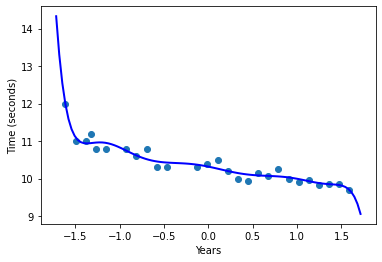

In [7]:
x_test = np.linspace(1880, 2020, 100)[:, None]  # Construct test data.
x_test = transform(x_test)  # Do the same rescaling to the test data.
X_test = make_polynomial(x_test, poly_order)  # Construct the polynomial matrix for test data.
f_test = poly_reg.predict(X_test)

plt.plot(x_test, f_test, 'b-', linewidth = 2)  # Plot the fitted data.
plt.scatter(x, t)  # Draw a scatter plot.
plt.xlabel('Years')
plt.ylabel('Time (seconds)')
plt.show()

### Task 3: Choosing Polynomial order with Cross-Validation

#### Task 3.1: Cross-Validation with a given Polynomial order.
Reference for `KFold`: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

In [8]:
from sklearn.model_selection import KFold

cv = KFold(n_splits = 5)  # Call KFold to set up 5-fold CV.
loss = []  # Initiate a list to collect loss.
reg = LinearRegression()  # Call a linear regression model.

poly_order = 9 
X_train = make_polynomial(x, poly_order)

for train_index, test_index in cv.split(X_train): 
    print('TRAIN:', train_index, 'TEST:', test_index)
    X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]  # Select X for training and testing.
    t_train_cv, t_test_cv = t[train_index], t[test_index]  # Select t for training and testing.
    reg.fit(X_train_cv, t_train_cv)  # Fit a model on the training data.
    loss.append(np.mean((t_test_cv - reg.predict(X_test_cv)) ** 2))  # Compute loss on test data and store it in the list.

print('Loss per fold:', loss)
print('Average loss:', np.mean(loss))

TRAIN: [ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26] TEST: [0 1 2 3 4 5]
TRAIN: [ 0  1  2  3  4  5 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26] TEST: [ 6  7  8  9 10 11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 17 18 19 20 21 22 23 24 25 26] TEST: [12 13 14 15 16]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 22 23 24 25 26] TEST: [17 18 19 20 21]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST: [22 23 24 25 26]
Loss per fold: [2331.1772252724763, 0.4133916880375302, 0.039626321155412855, 0.13148255026637343, 107.1293325404724]
Average loss: 487.77821167448155


#### Task 3.2: Cross-Validation for a range of Polynomial orders.

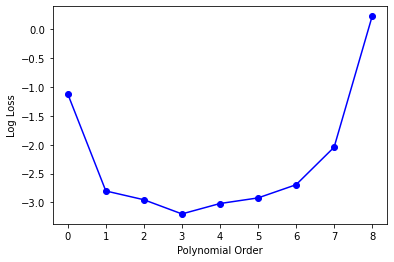

In [9]:
cv = KFold(n_splits = 10)  # Call KFold to set up 10-fold CV.
reg = LinearRegression()  # Call a linear regression model.
all_loss = []  # Initiate a list to collect loss.

for order in range(9):
    poly_order = order
    X_train = make_polynomial(x, poly_order) 
    loss_at_order = []  # Initiate a list to collect loss for CV.

    for train_index, test_index in cv.split(X_train):
        X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]  # Select X for training and testing.
        t_train_cv, t_test_cv = t[train_index], t[test_index]  # Select t for training and testing.
        reg.fit(X_train_cv, t_train_cv)  # Fit a model on the training data.
        loss_at_order.append(np.mean((t_test_cv - reg.predict(X_test_cv)) ** 2))  # Compute loss on test data and store it in the list.

    all_loss.append(np.mean(loss_at_order))

plt.plot(np.log(all_loss), 'bo-')  # Plot log(loss) at order.
plt.xlabel('Polynomial Order')
plt.ylabel('Log Loss')
plt.show()

### Task 4: Cross-Validation for Polynomial order on new data

In [10]:
np.random.seed(1)  # Fix random seed such that every time we get the same random numbers.

N = 100  # Total number of data points.
x = 10 * np.random.rand(N, 1) - 5  # Generate random x.
t = 5 * x ** 3 - x ** 2 + x + 200 * np.random.randn(N, 1)  # Generate t according to the true model with additive noise.

N_independent_test = 50  # Total number of independent testing data points.
x_independent_test = 10 * np.random.rand(N_independent_test, 1) - 5  # Generate independent testing x.
t_independent_test = 5 * x_independent_test ** 3 - x_independent_test ** 2 + x_independent_test + 200 * np.random.randn(N_independent_test, 1)  # Generate independent testing t with noise.

### Plot new data.

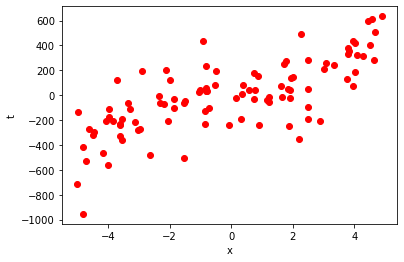

In [11]:
plt.plot(x, t, 'ro')
plt.xlabel('x')
plt.ylabel('t')
plt.show()

#### Task 4.1: Redo Cross-Validation for Polynomial order on new data. Plot CV loss, training loss, and loss on the independent test set

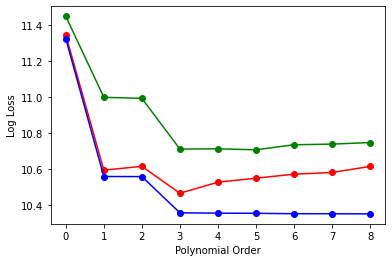

In [12]:
cv = KFold(n_splits = 10)
reg = LinearRegression()  # Model for CV.
reg_train = LinearRegression()  # Model for loss on training and independent test.
all_loss = []
all_loss_trian = []
all_loss_independent_test = []

for order in range(9): 
    poly_order = order 
    X_train = make_polynomial(x, poly_order)  # Construct polynomial matrix for all training data.
    reg_train.fit(X_train, t)  # Fit model on all training data.
    all_loss_trian.append(np.mean(( t - reg_train.predict(X_train)) ** 2))  # Collect training loss.
    X_independent_test = make_polynomial(x_independent_test, poly_order)  # Construct polynomial matrix for the independent test data.
    all_loss_independent_test.append(np.mean((t_independent_test - reg_train.predict(X_independent_test)) ** 2))  # Collect loss on independent test data.
    loss_at_order = []

    for train_index, test_index in cv.split(X_train):
        X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]  # Select X for training and testing.
        t_train_cv, t_test_cv = t[train_index], t[test_index]  # Select t for training and testing.
        reg.fit(X_train_cv, t_train_cv)  # Fit a model on the training data.
        loss_at_order.append(np.mean((t_test_cv - reg.predict(X_test_cv))**2))  # Collect loss at fold.
    
    all_loss.append(np.mean(loss_at_order))  # Collect loss at order.

plt.plot(np.log(all_loss), 'ro-') 
plt.plot(np.log(all_loss_trian), 'bo-')
plt.plot(np.log(all_loss_independent_test), 'go-')
plt.xlabel('Polynomial Order')
plt.ylabel('Log Loss')
plt.show()

### Task 5: Polynomial Linear Regression with L2 regression.

$$
\hat{\mathbf{w}}_{ridge} = \underset{\mathbf{w} }{\mathrm{argmin}}
 \frac{1}{N} (\mathbf{t} - \mathbf{X}\mathbf{w} )^{T} (\mathbf{t} - \mathbf{X}\mathbf{w} ) + \alpha \mathbf{w}^T \mathbf{w}
$$

Check out https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html for `Ridge`.

Check out https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html for `GridSearchCV`.

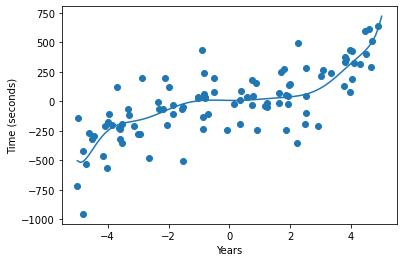

In [13]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

poly_order = 10 
X_train = make_polynomial(x, poly_order)  # Construct polynomial matrix on training data.
x_test = np.linspace(-5, 5, 100)[:, None]  # Generate x_test for plotting.
X_test = make_polynomial(x_test, poly_order)  # Construct polynomial matrix on x_test.

ridge = Ridge()  # Call ridge model.
parameters = {'alpha': np.linspace(1, 10, 20)}  # Set out search grid for alpha.
ridge_model = GridSearchCV(ridge, parameters, scoring = 'neg_mean_squared_error', cv = 5)  # Define CV on the search grid to define alpha.
ridge_model.fit(X_train, t)  # Fit training data.

plt.plot(x_test, ridge_model.predict(X_test))  # Plot the model.
plt.scatter(x,t)  # Draw a scatter plot.
plt.xlabel('Years')
plt.ylabel('Time (seconds)')
plt.show()

### Task 6 Practice linear regression with RBF. 

Write you own function to construct the design matrix with RBF. Again the `np.hstack()` function can be very helpful.

$$ h_k(x) = \exp \left( -\frac{ (x-\mbox{center}[k]) ^2}{2\mbox{width}}  \right)$$

In [14]:
def make_rbf(x, centre, width):
    '''
    Construct the design matrix with RBF.

    Parameters
    ----------
    x : data
    centre : the centre
    width : the width

    Returns
    -------
    data : constructed data
    '''

    X = np.exp(-0.5 * (x - centre[0]) ** 2 / width)

    for index in range(len(centre))[1:]:
        X = np.hstack((X, np.exp(-0.5 * (x - centre[index]) ** 2 / width)))
    
    return X

#### Task 6.2 Construct  the design matrix with $x$ itself as the center parameter
Start with `width = 10` and test different values

In [15]:
center = x 
width = 10
X_rbf = make_rbf(x, center, width)
print(X_rbf.shape)

(100, 100)


#### Task 6.2 Fit a linear regression model with X constructed by RBF

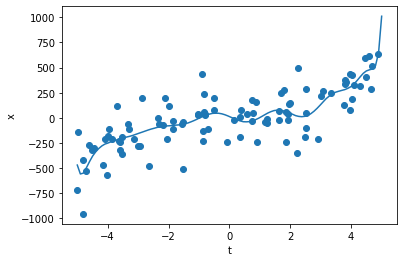

In [16]:
reg = LinearRegression()
reg.fit(X_rbf, t)
X_test = make_rbf(x_test, center, width)

plt.plot(x_test, reg.predict(X_test))
plt.scatter(x, t)
plt.xlabel('t')
plt.ylabel('x')
plt.show()